In [0]:
# library imports
import numpy as np 
import pandas as pd
import random as rn
import cv2 as cv 
import os
import sys
from pathlib import Path
# visuals
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [0]:
from google.colab import drive

# 4/xwG3EYU0xXaFDYxUDRQOuCzcKT8GNhXQVTiBcDheXBL7-XKSayH8RoU

drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
!pwd

/content


## 1. 데이터 전처리

In [0]:
#학습 데이터의 경로
img_train_folder = '/content/gdrive/My Drive/Semi-project/steal/train_images/'
#테스트 데이터의 경로
img_test_folder = '/content/gdrive/My Drive/Semi-project/steal/test_images/'

In [0]:
data = pd.read_csv('/content/gdrive/My Drive/Semi-project/steal/train.csv', sep=",")
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [0]:
# isolating the file name and class
#data['ImageId'], data['ClassId'] = data.ImageId_ClassId.str.split('_', n=1).str
data['ClassId'] = data['ClassId'].astype(np.uint8)

# storing a list of images without defects for later use and testing
no_defects = data[data['EncodedPixels'].isna()] \
                [['ImageId']] \
                .drop_duplicates()

# adding the columns so we can append (a sample of) the dataset if need be, later
no_defects['EncodedPixels'] = ''
no_defects['ClassId'] = np.empty((len(no_defects), 0)).tolist()
no_defects['Distinct Defect Types'] = 0
no_defects.reset_index(inplace=True)

In [0]:
# keep only the images with labels
squashed = data.dropna(subset=['EncodedPixels'], axis='rows', inplace=True)

# squash multiple rows per image into a list
squashed = data[['ImageId', 'EncodedPixels', 'ClassId']] \
            .groupby('ImageId', as_index=False) \
            .agg(list) \

# count the amount of class labels per image
squashed['Distinct Defect Types'] = squashed.ClassId.apply(lambda x: len(x))

# display first ten to show new structure
squashed

,ImageId,EncodedPixels,ClassId,Distinct Defect Types
0,0002cc93b.jpg,[29102 12 29346 24 29602 24 29858 24 30114 24 ...,[1],1
1,0007a71bf.jpg,[18661 28 18863 82 19091 110 19347 110 19603 1...,[3],1
2,000a4bcdd.jpg,[37607 3 37858 8 38108 14 38359 20 38610 25 38...,[1],1
3,000f6bf48.jpg,[131973 1 132228 4 132483 6 132738 8 132993 11...,[4],1
4,0014fce06.jpg,[229501 11 229741 33 229981 55 230221 77 23046...,[3],1
...,...,...,...,...
6661,ffcf72ecf.jpg,[121911 34 122167 101 122422 169 122678 203 12...,[3],1
6662,fff02e9c5.jpg,[207523 3 207777 9 208030 15 208283 22 208537 ...,[3],1
6663,fffe98443.jpg,[105929 5 106177 14 106424 24 106672 33 106923...,[3],1
6664,ffff4eaa8.jpg,[16899 7 17155 20 17411 34 17667 47 17923 60 1...,[3],1


In [0]:
def build_mask(encodings, labels):
    """ takes a pair of lists of encodings and labels, 
        and turns them into a 3d numpy array of shape (256, 1600, 4) 
    """
    
    # initialise an empty numpy array 
    mask = np.zeros((256,1600,4), dtype=np.uint8)
   
    # building the masks
    for rle, label in zip(encodings, labels):
        
        # classes are [1, 2, 3, 4], corresponding indeces are [0, 1, 2, 3]
        index = label - 1
        
        # fit the mask into the correct layer
        # note we need to transpose the matrix to account for 
        # numpy and openCV handling width and height in reverse order 
        mask[:,:,index] = rle_to_mask(rle).T
    
    return mask

In [0]:
def mask_to_contours(image, mask_layer, color):
    """ converts a mask to contours using OpenCV and draws it on the image
    """

    # https://docs.opencv.org/4.1.0/d4/d73/tutorial_py_contours_begin.html
    contours, hierarchy = cv.findContours(mask_layer, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    image = cv.drawContours(image, contours, -1, color, 2)
        
    return image

In [0]:
import seaborn as sns
palette = sns.color_palette("bright")

In [0]:
def visualise_mask(file_name, mask):
    """ open an image and draws clear masks, so we don't lose sight of the 
        interesting features hiding underneath 
    """
    
    # reading in the image
    image = cv.imread(f'{img_train_folder}/{file_name}')

    # going through the 4 layers in the last dimension 
    # of our mask with shape (256, 1600, 4)
    for index in range(mask.shape[-1]):
        
        # indeces are [0, 1, 2, 3], corresponding classes are [1, 2, 3, 4]
        label = index + 1
        
        # add the contours, layer per layer 
        image = mask_to_contours(image, mask[:,:,index], color=palette[label])   
        
    return image

In [0]:
def rle_to_mask(lre, shape=(1600,256)):
    '''
    params:  rle   - run-length encoding string (pairs of start & length of encoding)
             shape - (width,height) of numpy array to return 
    
    returns: numpy array with dimensions of shape parameter
    '''    
    # the incoming string is space-delimited
    runs = np.asarray([int(run) for run in lre.split(' ')])
    
    # we do the same operation with the even and uneven elements, but this time with addition
    runs[1::2] += runs[0::2]
    # pixel numbers start at 1, indexes start at 0
    runs -= 1
    
    # extract the starting and ending indeces at even and uneven intervals, respectively
    run_starts, run_ends = runs[0::2], runs[1::2]
    
    # build the mask
    h, w = shape
    mask = np.zeros(h*w, dtype=np.uint8)
    for start, end in zip(run_starts, run_ends):
        mask[start:end] = 1
    
    # transform the numpy array from flat to the original image shape
    return mask.reshape(shape)

In [0]:
# we want counts of the possible combinations of labels
permutations = pd.DataFrame(data=squashed.ClassId.astype(str).value_counts())

# and their frequency
permutations['Frequency'] = round(permutations.ClassId / permutations.ClassId.sum() * 100, 2)
permutations['Frequency'] = permutations['Frequency'].astype(str) + '%'

# plotly for interactive graphs
fig = go.Figure(
    
    data=go.Bar(
        orientation='h',
        x=permutations.ClassId,
        y=permutations.index,
        hovertext=permutations.Frequency,
        text=permutations.ClassId,
        textposition='auto'),
    
    layout=go.Layout(
        title='Count of Distinct Defect Combinations in Images',
        showlegend=False,
        xaxis=go.layout.XAxis(showticklabels=False),
        yaxis=go.layout.YAxis(autorange='reversed'),
        width=750, height=500
    )
)

# display
fig.show()

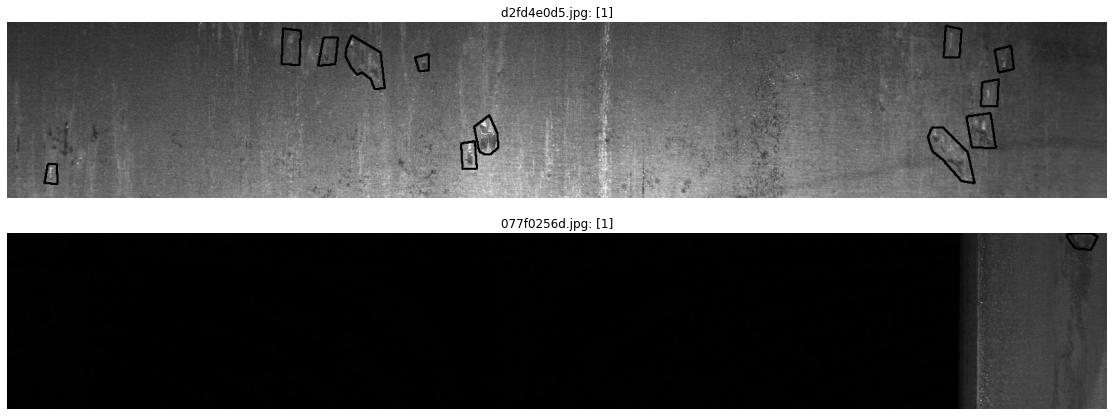

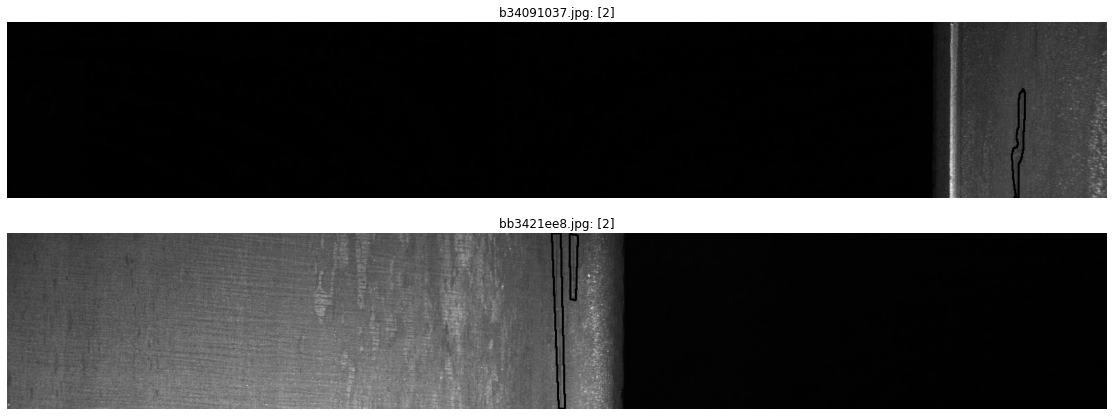

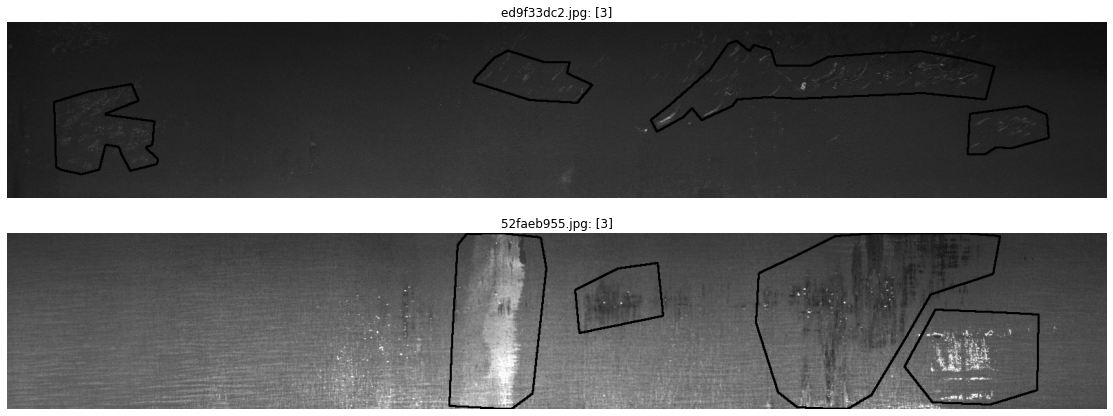

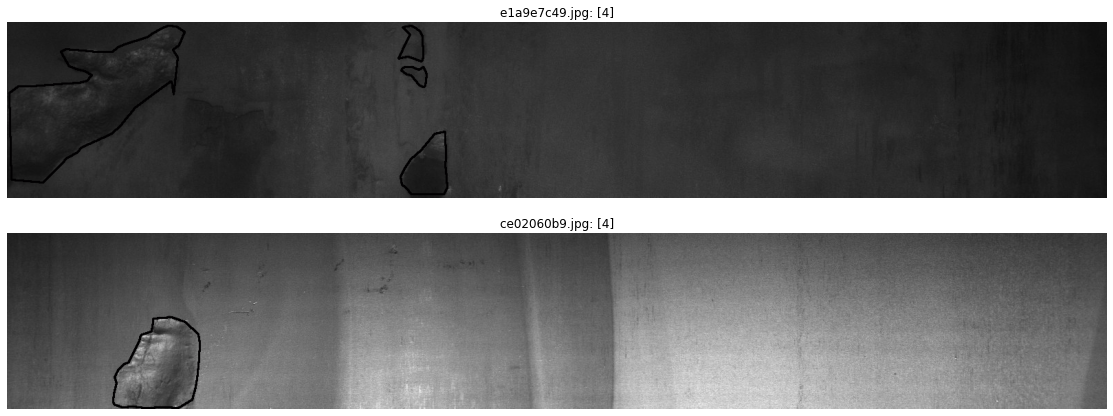

In [0]:
conditions = [
    squashed['ClassId'].astype(str)=='[1]',
    squashed['ClassId'].astype(str)=='[2]',
    squashed['ClassId'].astype(str)=='[3]',
    squashed['ClassId'].astype(str)=='[4]'
]

# max 2 due to limited population of [squashed['Distinct Defect Types']==3]
# remove that condition if you wish to increase the sample size, 
# or add replace=True to the .sample() method
sample_size = 2

# looping over the different combinations of labels 
for condition in conditions:
    
    # isolate from dataset and draw a sample
    sample = squashed[condition].sample(sample_size) 
    
    # make a subplot+
    fig, axes = plt.subplots(sample_size, 1, figsize=(16, sample_size*3))
    fig.tight_layout()
    
    # looping over sample
    for i, (index, row) in enumerate(sample.iterrows()):
        
        # current ax
        ax = axes[i,]
        
        # build the mask
        mask = build_mask(encodings=row.EncodedPixels, labels=row.ClassId)

        # fetch the image and draw the contours
        image = visualise_mask(file_name=row.ImageId, mask=mask)
         # display
        ax.set_title(f'{row.ImageId}: {row.ClassId}')
        ax.axis('off')
        ax.imshow(image)
        
       

In [0]:
!git clone https://www.github.com/matterport/Mask_RCNN.git 
# results in Commit Error (too many nested subdirectories)

""" Credit to Simon Walker, whose method helped me to 
    circumvent the commit error. Check out his kernel at 
    https://www.kaggle.com/srwalker101/mask-rcnn-model
"""
#!pip install git+https://github.com/rteuwens/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.84 MiB | 11.03 MiB/s, done.
Resolving deltas: 100% (570/570), done.


' Credit to Simon Walker, whose method helped me to \n    circumvent the commit error. Check out his kernel at \n    https://www.kaggle.com/srwalker101/mask-rcnn-model\n'

In [0]:
import os
os.chdir('Mask_RCNN')

In [0]:
WORKING_DIR = '.'
LOGS_DIR = os.path.join(WORKING_DIR, "logs")
MASK_RCNN_DIR = os.path.join(WORKING_DIR, 'Mask_RCNN-master')

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

Using TensorFlow backend.


In [0]:
class SeverstalConfig(Config):

    NAME = "severstal"
    IMAGES_PER_GPU = 1

    # 분류할 클래스 개수
    NUM_CLASSES = 1 + 4  # background + steel defects

    # epoch당 training 단계 수
    STEPS_PER_EPOCH = 100

    # 60% 이하의 신뢰도를 가진 detection은 제외
    DETECTION_MIN_CONFIDENCE = 0.6
    
    # 성능이 낮은 가중치는 제외
    SAVE_BEST_ONLY = True
    
# SeverstalConfig 클래스 인스턴스 생성
severstal_config = SeverstalConfig()

In [0]:
# super class can be found here:
# https://github.com/matterport/Mask_RCNN/blob/v2.1/utils.py

class SeverstalDataset(Dataset):
    
    def __init__(self, dataframe):
        
        # https://rhettinger.wordpress.com/2011/05/26/super-considered-super/
        super().__init__(self)
        
        # needs to be in the format of our squashed df, 
        # i.e. image id and list of rle plus their respective label on a single row
        self.dataframe = dataframe
        
    def load_dataset(self, subset='train'):
        """ takes:
                - pandas df containing 
                    1) file names of our images 
                       (which we will append to the directory to find our images)
                    2) a list of rle for each image 
                       (which will be fed to our build_mask() 
                       function we also used in the eda section)         
            does:
                adds images to the dataset with the utils.Dataset's add_image() method
        """
        
        # input hygiene
        assert subset in ['train', 'test'], f'"{subset}" is not a valid value.'
        img_folder = img_train_folder if subset=='train' else img_test_folder
        
        # add our four classes
        for i in range(1,5):
            self.add_class(source='', class_id=i, class_name=f'defect_{i}')
        
        # add the image to our utils.Dataset class
        for index, row in self.dataframe.iterrows():
            file_name = row.ImageId
            file_path = f'{img_folder}/{file_name}'
            
            assert os.path.isfile(file_path), 'File doesn\'t exist.'
            self.add_image(source='', 
                           image_id=file_name, 
                           path=file_path)
    
    def load_mask(self, image_id):
        """As found in: 
            https://github.com/matterport/Mask_RCNN/blob/master/samples/coco/coco.py
        
        Load instance masks for the given image
        
        This function converts the different mask format to one format
        in the form of a bitmap [height, width, instances]
        
        Returns:
            - masks    : A bool array of shape [height, width, instance count] with
                         one mask per instance
            - class_ids: a 1D array of class IDs of the instance masks
        """
        
        # find the image in the dataframe
        row = self.dataframe.iloc[image_id]
        
        # extract function arguments
        rle = row['EncodedPixels']
        labels = row['ClassId']
        
        # create our numpy array mask
        mask = build_mask(encodings=rle, labels=labels)
        
        # we're actually doing semantic segmentation, so our second return value is a bit awkward
        # we have one layer per class, rather than per instance... so it will always just be 
        # 1, 2, 3, 4. See the section on Data Shapes for the Labels.
        return mask.astype(np.bool), np.array([1, 2, 3, 4], dtype=np.int32)

In [0]:
RANDOM_SEED = 42

In [0]:
from sklearn.model_selection import train_test_split

train, validate = train_test_split(squashed, test_size=0.2, random_state=RANDOM_SEED)

In [0]:
print(train['ClassId'].astype(str).value_counts(normalize=True))


[3]          0.716992
[1]          0.112716
[4]          0.076144
[3, 4]       0.041448
[2]          0.031133
[1, 3]       0.012566
[1, 2]       0.006189
[2, 3]       0.002251
[1, 2, 3]    0.000375
[2, 4]       0.000188
Name: ClassId, dtype: float64


In [0]:
print(validate['ClassId'].astype(str).value_counts(normalize=True))

[3]       0.701649
[1]       0.125937
[4]       0.082459
[3, 4]    0.047226
[2]       0.021739
[1, 3]    0.017991
[1, 2]    0.001499
[2, 3]    0.001499
Name: ClassId, dtype: float64


In [0]:
%%time

# training 데이터 셋 생성
dataset_train = SeverstalDataset(dataframe=train)
dataset_train.load_dataset()
dataset_train.prepare()

# validation 데이터 셋 생성
dataset_validate = SeverstalDataset(dataframe=validate)
dataset_validate.load_dataset()
dataset_validate.prepare()

CPU times: user 1.5 s, sys: 465 ms, total: 1.97 s
Wall time: 7.95 s


In [0]:
!curl -LO https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   608  100   608    0     0   2543      0 --:--:-- --:--:-- --:--:--  2543
100  245M  100  245M    0     0  30.2M      0  0:00:08  0:00:08 --:--:-- 35.3M


In [0]:
import tensorflow as tf

In [0]:
# 환경설정
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# session
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
session.run(tf.local_variables_initializer())

# train을 위한 모델 생성
model = MaskRCNN(mode='training', config=severstal_config, model_dir='modeldir')

# 학습시키기 전 coco 가중치를 사용
model.load_weights('mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=['mrcnn_bbox_fc',
                            'mrcnn_class_logits', 
                            'mrcnn_mask',
                            'mrcnn_bbox'])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead






In [0]:
%%time 

# ignore UserWarnongs
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# training at last
model.train(dataset_train,
            dataset_validate,
            epochs=10,
            layers='heads',
            learning_rate=severstal_config.LEARNING_RATE)



Starting at epoch 0. LR=0.001

Checkpoint Path: modeldir/severstal20200320T1421/mask_rcnn_severstal_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4        

In [0]:
history = model.keras_model.history.history

In [0]:
history

{'loss': [2.512944142818451,
  2.12248440861702,
  2.025080706179142,
  1.85289188683033,
  1.804032352566719,
  1.7871005457639695,
  1.7142190384864806,
  1.9729161012172698,
  1.7385096108913423,
  1.7350294864177704],
 'mrcnn_bbox_loss': [0.832306307554245,
  0.6538922590017319,
  0.603848844319582,
  0.475748372823,
  0.5660210971534252,
  0.47363050520420075,
  0.5239038037508726,
  0.45772863760590554,
  0.4808629697561264,
  0.4566497457027435],
 'mrcnn_class_loss': [0.1565294870777143,
  0.0993760606784781,
  0.08891557409668166,
  0.08467146704744664,
  0.10504616073787475,
  0.09401185408343736,
  0.09874033939180663,
  0.09709825538243422,
  0.09751277962699532,
  0.1070906480027952],
 'mrcnn_mask_loss': [0.45277539290487767,
  0.4911995779722929,
  0.42596241876482965,
  0.38263227496296165,
  0.38737206533551216,
  0.4058273757994175,
  0.41661618497222663,
  0.3718127210438251,
  0.43671586975455284,
  0.4107844857126474],
 'rpn_bbox_loss': [0.9636432588845492,
  0.83876

In [0]:
class InferenceConfig(SeverstalConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# inference(Test) mode로 새로운 모델 생성
model = MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir='modeldir')

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  modeldir/severstal20200320T1421/mask_rcnn_severstal_0010.h5
Re-starting from epoch 10


In [0]:
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import visualize
import random

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  193.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1600.00000  float64
gt_class_id              shape: (1,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (1, 4)                min:  431.00000  max:  941.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


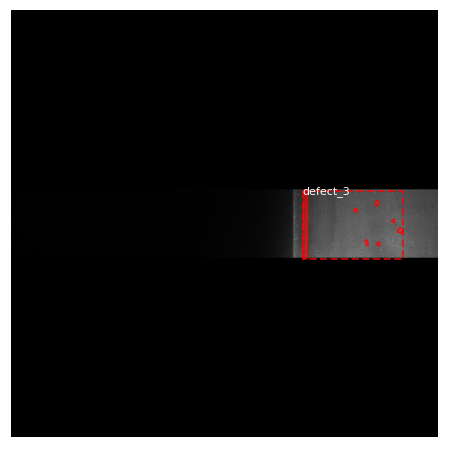

In [0]:
# Test on a random image
image_id = random.choice(dataset_validate.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_validate, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [0]:
model.keras_model.save("/content/gdrive/My Drive/Semi-project/mrcnn_0320.h5")
print("Saved model to disk")

Saved model to disk
